In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import datetime as dt
import matplotlib.pyplot as plt

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

# Data Preparation

In [2]:
df_resp = pd.read_csv('Retail_Data_Response.csv')
df_trans = pd.read_csv('Retail_Data_Transactions.csv', parse_dates=['trans_date'])

In [3]:
df_resp.head()

,customer_id,response
0,CS1112,0
1,CS1113,0
2,CS1114,1
3,CS1115,1
4,CS1116,1


In [4]:
df_trans.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [5]:
df_trans['recent'] = (dt.datetime(2015,3,17)-df_trans['trans_date']).astype('timedelta64[D]')
df_trans.head()

,customer_id,trans_date,tran_amount,recent
0,CS5295,2013-02-11,35,764.0
1,CS4768,2015-03-15,39,2.0
2,CS2122,2013-02-26,52,749.0
3,CS1217,2011-11-16,99,1217.0
4,CS1850,2013-11-20,78,482.0


In [7]:
df_rfm = df_trans.groupby('customer_id').agg({'recent': lambda x: x.min(), 'customer_id': lambda x: len(x), 'tran_amount': lambda x: x.sum(), 'trans_date': lambda x:(x.max()-x.min()).days})
df_rfm.rename(columns={'recent': 'recency', 'customer_id': 'frequency', 'tran_amount': 'monetary_value', 'trans_date':'aou'}, inplace=True)
df_rfm['ticket_size'] = df_rfm['monetary_value']/df_rfm['frequency']
df_rfm = df_rfm.reset_index()
df_rfm.head()

,customer_id,recency,frequency,monetary_value,aou,ticket_size
0,CS1112,62.0,15,1012,1309,67.466667
1,CS1113,36.0,20,1490,1354,74.500000
2,CS1114,33.0,19,1432,1309,75.368421
3,CS1115,12.0,22,1659,1303,75.409091
4,CS1116,204.0,13,857,1155,65.923077


In [8]:
df_model = pd.merge(df_resp,df_rfm)
df_model.head()

,customer_id,response,recency,frequency,monetary_value,aou,ticket_size
0,CS1112,0,62.0,15,1012,1309,67.466667
1,CS1113,0,36.0,20,1490,1354,74.500000
2,CS1114,1,33.0,19,1432,1309,75.368421
3,CS1115,1,12.0,22,1659,1303,75.409091
4,CS1116,1,204.0,13,857,1155,65.923077


In [9]:
X = df_model.drop(columns=['response','customer_id'])
y = df_model['response']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

print('Number transactions X_train dataset: ', X_train.shape)
print('Number transactions y_train dataset: ', y_train.shape)
print('Number transactions X_test dataset: ', X_test.shape)
print('Number transactions y_test dataset: ', y_test.shape)

Number transactions X_train dataset:  (4818, 5)
Number transactions y_train dataset:  (4818,)
Number transactions X_test dataset:  (2066, 5)
Number transactions y_test dataset:  (2066,)


# EDA

Text(0.5, 1.0, 'Data')

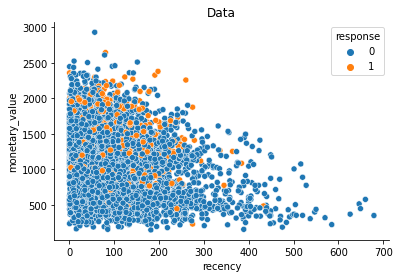

In [10]:
sns.scatterplot(data=df_model, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Data")

Text(0.5, 1.0, 'Undersampled Data')

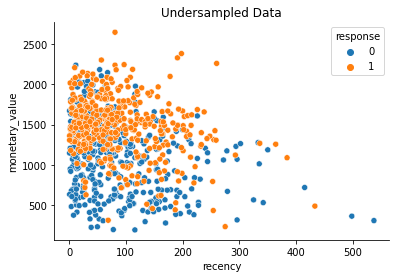

In [11]:
# undersampling
rus = RandomUnderSampler(random_state=0).fit(X_train, y_train)
X_undersampled, y_undersampled = rus.fit_resample(X_train, y_train)
df_undersampled = pd.concat([pd.DataFrame(data=X_undersampled), pd.DataFrame(data=y_undersampled)], axis=1, sort=False)
df_undersampled.columns = ['recency', 'frequency', 'monetary_value', 'aou', 'ticket_size', 'response']

sns.scatterplot(data = df_undersampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Undersampled Data")

Text(0.5, 1.0, 'Oversampled Data')

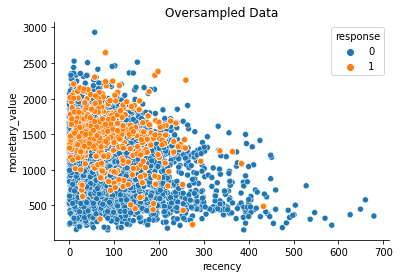

In [12]:
# oversampling
ros = RandomOverSampler(random_state=0).fit(X_train, y_train)
X_oversampled, y_oversampled = ros.fit_resample(X_train, y_train)
df_oversampled = pd.concat([pd.DataFrame(data=X_oversampled), pd.DataFrame(data=y_oversampled)], axis=1, sort=False)
df_oversampled.columns= ['recency', 'frequency', 'monetary_value', 'aou', 'ticket_size', 'response']

sns.scatterplot(data=df_oversampled, x='recency', y='monetary_value', hue='response')
sns.despine()
plt.title("Oversampled Data")

# XGBoost

In [13]:
def train_model(ML, X_train, y_train, X_test, y_test, model_parameter={}):
    predicted_y = []
    expected_y = []

    model = ML.fit(X=X_train, y=y_train, **model_parameter)
    predictions = model.predict(X_train)
    predicted_y.extend(predictions)
    expected_y.extend(y_train)
    report_train = classification_report(expected_y, predicted_y)
    print('------------------- TRAINING SET -------------------')
    print()
    print(report_train)

    predicted_y = []
    expected_y = []
    
    predictions = model.predict(X_test.to_numpy())
    predicted_y.extend(predictions)
    expected_y.extend(y_test)
    report_test = classification_report(expected_y, predicted_y)
    print('--------------------- TEST SET ---------------------')
    print()
    print(report_test) 

    return model

def plot_roc(X_train, y_train, X_test, y_test, func):
    y_score_train = func(X_train)
    
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train[:,1])
    auc_train = roc_auc_score(y_train, y_score_train[:,1])
    
    plt.plot(fpr_train, tpr_train, color='red', label='train , auc='+str(auc_train))
    
    y_score_test = func(X_test.to_numpy())
    
    fpr_test, tpr_test, _ = roc_curve(y_test,  y_score_test[:,1])
    auc_test = roc_auc_score(y_test, y_score_test[:,1])
    
    plt.plot(fpr_test, tpr_test, color='Blue', label='test , auc='+str(auc_test))
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.legend(loc=4)
    plt.show()

## Undersampling

In [14]:
model_parameter = {'early_stopping_rounds':10, 'eval_set':[(X_test, y_test)]}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
xgb_model_under = train_model(xgb_model, X_undersampled, y_undersampled, X_test, y_test, model_parameter)

[0]	validation_0-auc:0.66976
[1]	validation_0-auc:0.69308
[2]	validation_0-auc:0.69666
[3]	validation_0-auc:0.70057
[4]	validation_0-auc:0.70275
[5]	validation_0-auc:0.70295
[6]	validation_0-auc:0.70025
[7]	validation_0-auc:0.70584
[8]	validation_0-auc:0.70417
[9]	validation_0-auc:0.70170
[10]	validation_0-auc:0.70274
[11]	validation_0-auc:0.70096
[12]	validation_0-auc:0.70189
[13]	validation_0-auc:0.70261
[14]	validation_0-auc:0.70119
[15]	validation_0-auc:0.70002
[16]	validation_0-auc:0.70374
[17]	validation_0-auc:0.70191
------------------- TRAINING SET -------------------

              precision    recall  f1-score   support

           0       0.92      0.83      0.87       429
           1       0.85      0.92      0.88       429

    accuracy                           0.88       858
   macro avg       0.88      0.88      0.88       858
weighted avg       0.88      0.88      0.88       858

--------------------- TEST SET ---------------------

              precision    recall  

C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


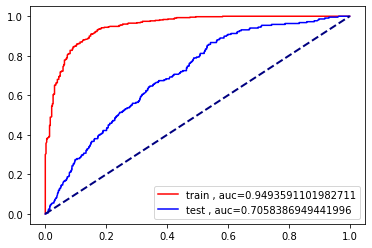

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

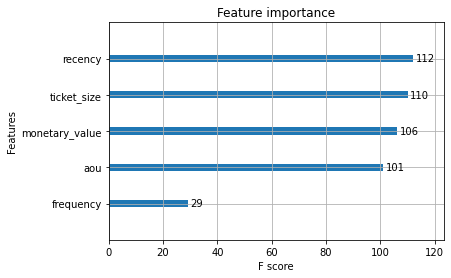

In [15]:
plot_roc(X_undersampled, y_undersampled, X_test, y_test, xgb_model.predict_proba)
xgb.plot_importance(xgb_model)

## Oversampling

In [16]:
model_parameter = {'early_stopping_rounds':10, 'eval_set':[(X_test, y_test)]}

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric="auc")
xgb_model_under = train_model(xgb_model, X_oversampled, y_oversampled, X_test, y_test, model_parameter)

[0]	validation_0-auc:0.69169
[1]	validation_0-auc:0.70181
[2]	validation_0-auc:0.70468
[3]	validation_0-auc:0.71194
[4]	validation_0-auc:0.71461
[5]	validation_0-auc:0.71181
[6]	validation_0-auc:0.70590
[7]	validation_0-auc:0.70774
[8]	validation_0-auc:0.70713
[9]	validation_0-auc:0.70215
[10]	validation_0-auc:0.70341
[11]	validation_0-auc:0.70333
[12]	validation_0-auc:0.70460
[13]	validation_0-auc:0.69775


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


------------------- TRAINING SET -------------------

              precision    recall  f1-score   support

           0       0.92      0.68      0.78      4389
           1       0.75      0.94      0.83      4389

    accuracy                           0.81      8778
   macro avg       0.83      0.81      0.81      8778
weighted avg       0.83      0.81      0.81      8778

--------------------- TEST SET ---------------------

              precision    recall  f1-score   support

           0       0.94      0.66      0.77      1848
           1       0.18      0.63      0.28       218

    accuracy                           0.65      2066
   macro avg       0.56      0.64      0.53      2066
weighted avg       0.86      0.65      0.72      2066



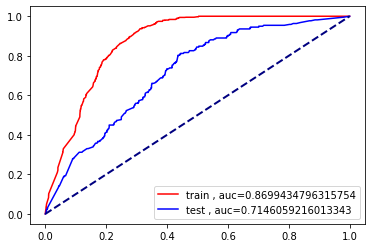

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

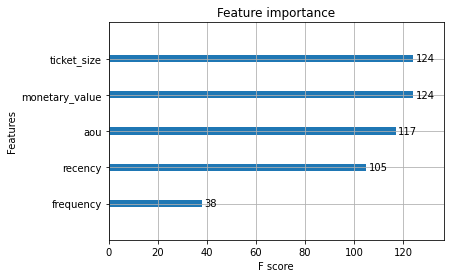

In [17]:
plot_roc(X_oversampled, y_oversampled, X_test, y_test, xgb_model.predict_proba)
xgb.plot_importance(xgb_model)